In [1]:
import numpy as np
import pandas as pd
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt


In [2]:
# 임의의 가상 시계열 데이터 생성

data = np.random.randn(1000).cumsum()
# np.random.randn(100) : 표준 정규 분포(평균 0, 표준 편차 1)에서 무작위로 샘플링한 100개의 숫자 생성
# cumsum(): 랜덤 숫자들의 누적 합 계산.. 랜덤 워크(random walk) 생성
      # 랜덤 워크(random walk): 무작위로 발생하는 이벤트들의 결과를 순차적으로 나열한 것
      # 다음 단계가 전 단계의 결과에 의존하지 않고 무작위로 결정되는 과정 ex) 술취한 사람의 다음 걸음 걸이... 예측 불가능
   # 랜덤한 변화량들을 차례로 누적해 감으로써, 시간이 지남에 따라 어떻게 값이 변화하는지를 보여주는 누적 경로 생성

# data

In [3]:
# Pandas 시리즈로 변환
time_series = pd.Series(data, index=pd.date_range(start='20200101', periods=1000))

# pd.Series()를 사용하여 NumPy 배열을 Pandas 시리즈로 변환
# 인덱스로 날짜 범위를 지정,  시계열 데이터로 생성
# 'start'와 'end'는 예측할 시계열의 시작과 끝 인덱스 지정
# Pandas ... 날짜 및 시간 인덱스를 가진 데이터에 대해 다양한 시간 기반의 기능을 제공

In [4]:
# ARIMA 모델을 데이터에 적합
# 데이터의 과거 값, 차분을 통한 추세 변화, 그리고 예측 오차의 패턴을 모두 고려하여 미래 값을 예측
# 모델 파라미터 (p=1, d=1, q=1)
   # p: 자기 회귀(AR)의 차수, d: 차분(I)의 차수, q: 이동 평균(MA)의 차수
model = ARIMA(time_series, order=(1, 1, 1))

model_fit = model.fit()


# AR(p) - 자기회귀(AutoRegressive):  이전 관측값의 영향을 나타냄,
   # 'p' = 과거 관측값의 수, p=1 -> 하나의 과거 관측값을 사용.
   # 현재 값이 바로 이전 값에 어느 정도 의존하는지에 대한 모델링 설정

# I(d) - 차분(Integrated): 데이터의 비정상성을 제거하기 위해 필요한 차분의 횟수
   # 'd'는 차분의 차수, d=1 -> 데이터를 한 번 차분(주어진 시계열의 변화분을 구하는 과정)
   #  과정은 데이터에서 추세를 제거하여 시계열이 정상성을 가지도록 돕습니다.

# MA(q) - 이동평균(Moving Average): 예측 오차의 이동평균
   # 'q' 과거 예측 오차의 수 q=1은 하나의 과거 예측 오차를 사용
   # 현재의 예측값이 이전의 예측 오차에 어느 정도 영향을 받는지에 대한 모델링 설정



In [5]:
# 다음 10 기간에 대한 데이터를 예측
forecast = model_fit.forecast(steps=100)

print(forecast)

2022-09-27   -1.228589
2022-09-28   -1.253086
2022-09-29   -1.237537
2022-09-30   -1.247406
2022-10-01   -1.241142
                ...   
2022-12-31   -1.243574
2023-01-01   -1.243574
2023-01-02   -1.243574
2023-01-03   -1.243574
2023-01-04   -1.243574
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


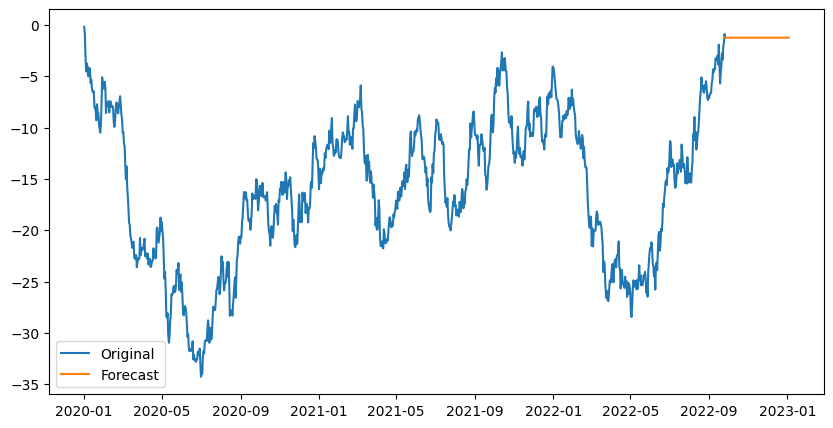

In [6]:
# 원본 데이터와 예측 결과를 함께 그래프로 표시
plt.figure(figsize=(10,5))
plt.plot(time_series, label='Original')
plt.plot(pd.date_range(start='20220926', periods=100, freq='D'), forecast, label='Forecast')
plt.legend()
plt.show()

In [7]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

spy = yf.download('spy', start='2020-04-01', end='2021-04-01')
ar = spy[["Close"]].copy()

[*********************100%%**********************]  1 of 1 completed


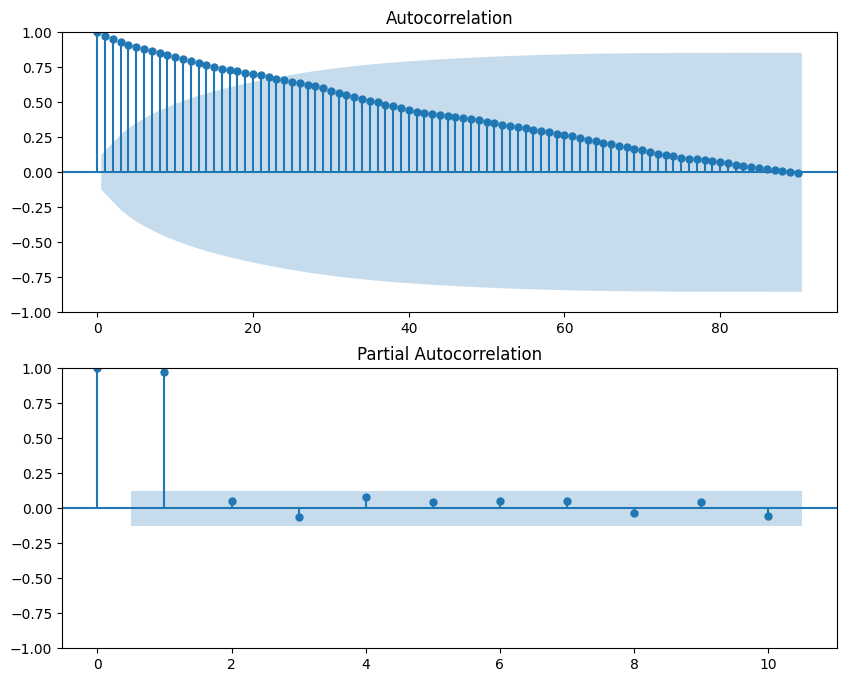

In [8]:
# ACF 및 PACF 플롯 그리기
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8))

plot_acf(ar['Close'], ax=ax1, lags=90)
plot_pacf(ar['Close'], ax=ax2, lags=10);

<AxesSubplot: xlabel='Date'>

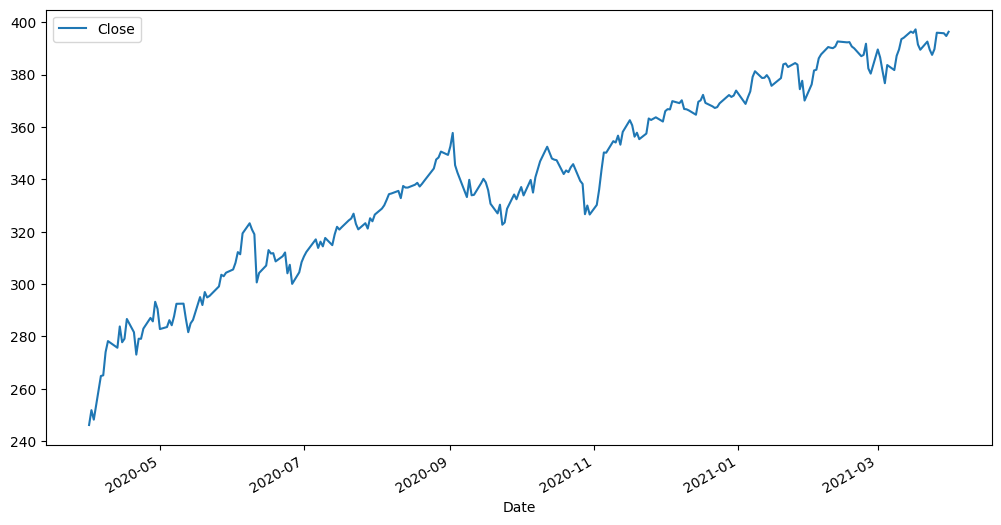

In [9]:
#시각화
ar.plot(figsize=(12.2, 6.4))

In [10]:
from statsmodels.tsa.stattools import adfuller

def diff_result(diffs):
    print(diffs,'차분에 대한 ADF test with spy time-series')
    ADF_result = adfuller(ar.diff(diffs).dropna())
    #ADF 통계량
    print('ADF Stats: %f' % ADF_result[0])
    #p-값
    print('p-value: %f' % ADF_result[1])
    #임계값
    print('Critical values:' )
    for key, value in ADF_result[4].items():
     print('\t%s: %.4f' % (key, value))

diff_result(1)

1 차분에 대한 ADF test with spy time-series
ADF Stats: -6.004145
p-value: 0.000000
Critical values:
	1%: -3.4586
	5%: -2.8740
	10%: -2.5734


In [11]:
full_date_range = pd.date_range(start=ar.index.min(), end=ar.index.max())
ar = ar.reindex(full_date_range)
ar = ar.fillna(method='ffill')

In [12]:
model = ARIMA(ar['Close'], order=(25, 1, 1)) # 순서대로 AR, Integreted, MA(q)
# 자기 회귀 : 90 이상에서 0으로 수렴하게 되어 의미는 없어보인다.
# 차분 : 1 로 두었을 때 정상성이 있음을 확인했다.
# Ma(q) : 부분 자기 상관에서 2 이후로 급감을 보였다.
model_fit = model.fit()

In [13]:
# 다음 100 기간에 대한 데이터를 예측
forecast = model_fit.forecast(steps=100)

print(forecast)

2021-04-01    396.387492
2021-04-02    395.778430
2021-04-03    393.874746
2021-04-04    394.098687
2021-04-05    393.994035
                 ...    
2021-07-05    394.510358
2021-07-06    394.510177
2021-07-07    394.502765
2021-07-08    394.502399
2021-07-09    394.508559
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


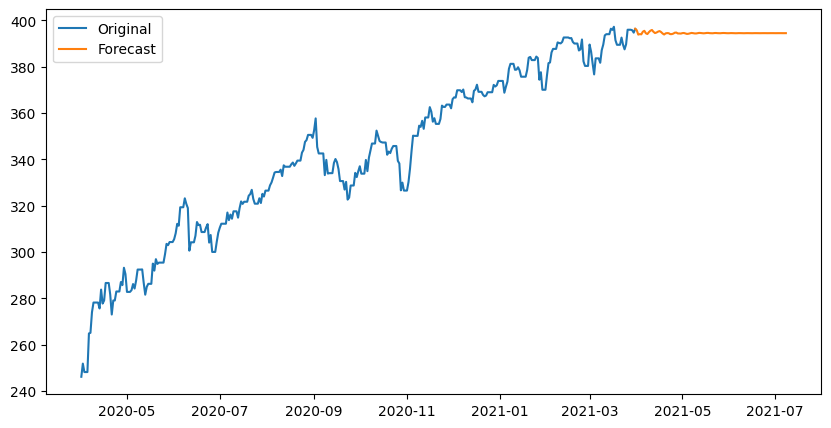

In [14]:
# 원본 데이터와 예측 결과를 함께 그래프로 표시
plt.figure(figsize=(10,5))
plt.plot(ar, label='Original')
plt.plot(pd.date_range(start=ar.index.max(), periods=100, freq='D'), forecast, label='Forecast')
plt.legend()
plt.show()

In [15]:
model = ARIMA(ar['Close'], order=(2, 1, 2))
# 여기서 처음 AR 값은 부분 자기 상관계수때 구한 값을 이용
model_fit = model.fit()

In [16]:
# 다음 100 기간에 대한 데이터를 예측
forecast = model_fit.forecast(steps=100)

print(forecast)

2021-04-01    395.686525
2021-04-02    396.438721
2021-04-03    396.060814
2021-04-04    395.863740
2021-04-05    396.455754
                 ...    
2021-07-05    396.103488
2021-07-06    396.106438
2021-07-07    396.108031
2021-07-08    396.103340
2021-07-09    396.107880
Freq: D, Name: predicted_mean, Length: 100, dtype: float64


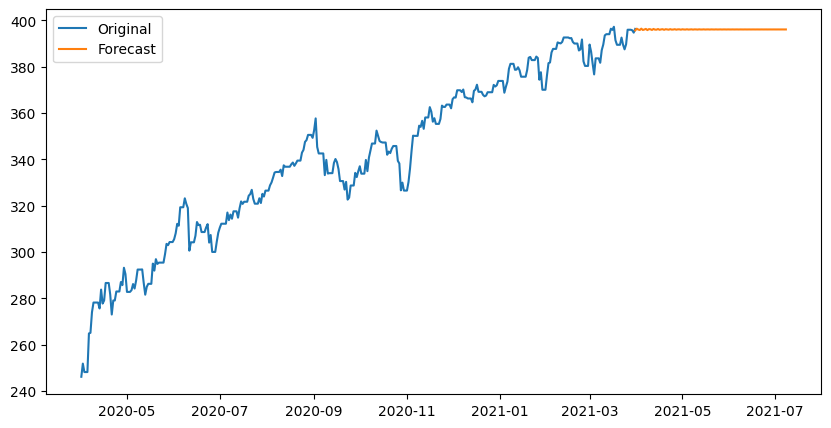

In [17]:
# 원본 데이터와 예측 결과를 함께 그래프로 표시
plt.figure(figsize=(10,5))
plt.plot(ar, label='Original')
plt.plot(pd.date_range(start=ar.index.max(), periods=100, freq='D'), forecast, label='Forecast')
plt.legend()
plt.show()